# Can figure out substrate uptake hierarchy without running the whole simulation

# Match individual growth rates first
# Using coarse model

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['svg.fonttype'] = 'none'
pd.set_option('display.max_colwidth', -1)
%matplotlib inline

In [3]:
PROTOTYPE = False

In [4]:
from dynamicme.tests.helpme import HelpME
from dynamicme.dynamic import get_cplx_concs

helper = HelpME(prototyping=PROTOTYPE)
solver = helper.solver
me = solver.me

## Change keffs until uptake hierarchy correct

In [87]:
import numpy as np

df_dh = pd.read_csv('/home/laurence/ME/data/DHeckmann/kappmax_rf_dl_iJO.csv')

import re
from cobra.io import load_json_model

ijo = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

rows = []
biggids = df_dh['bigg.id'].apply(lambda x: re.sub(r'(_[b|f]$)', '',x)).unique()
missed = []
for biggid in biggids:
    try:
        sdata = me.stoichiometric_data.get_by_id(biggid)
        mrxn = ijo.reactions.get_by_id(biggid)
        rname = mrxn.name        
        for rxn in sdata.parent_reactions:
            mmol_gDW = rxn.x / rxn.keff / 3600
            rows.append({'bigg_id':biggid, 'rxn':rxn.id, 'name':rname, 'keff_nominal':rxn.keff, 'subsystem':mrxn.subsystem, 'reaction':mrxn.reaction, 'mmol_gDW':mmol_gDW})
    except KeyError:
        missed.append(biggid)
        
df_rmap = pd.DataFrame(rows)
        
print 'biggids not mapped:', len(missed)

biggids not mapped: 252


In [92]:
print 'Subsystems:', len(df_rmap.subsystem.unique())
print 'Rxns within alternate carbon metab:', len(df_rmap.rxn[ df_rmap.subsystem=='Alternate Carbon Metabolism'])

ProtM = df_rmap.mmol_gDW.sum()
print 'Expressed protein (mmol/gDW):', ProtM

Subsystems: 35
Rxns within alternate carbon metab: 285
Expressed protein (mmol/gDW): 0.00495155284852


In [207]:
%%time

KEFF_SCALE = 0.42

from cobra import Metabolite, Reaction

ijomc = load_json_model('/home/laurence/ME/models/BiGG_M/json/iJO1366.json')

cons_crowding = Metabolite('crowding')
ijomc.add_metabolites([cons_crowding])

# sum_j v/keff  <= P [mmol/gDW]

for rid in df_rmap.bigg_id.unique():
    row = df_rmap[ df_rmap.bigg_id==rid].iloc[0]
    rxn = ijomc.reactions.get_by_id(rid)
    if rxn.lower_bound < 0:
        rxn_abs = Reaction(rxn.id + '_abs')
        ijomc.add_reaction(rxn_abs)
        # rabs >= r  :  rabs - r >= 0
        # rabs >= -r :  rabs + r >= 0        
        cons_abs_p = Metabolite('cons_'+rxn.id+'_abs_p')
        cons_abs_n = Metabolite('cons_'+rxn.id+'_abs_n')
        cons_abs_p._constraint_sense = 'G'
        cons_abs_n._constraint_sense = 'G'
        rxn_abs.add_metabolites({cons_abs_p: 1., cons_abs_n: 1.})
        rxn.add_metabolites({cons_abs_p:-1., cons_abs_n:1.})
        keff = row['keff_nominal'] * KEFF_SCALE
        rxn_abs.add_metabolites({cons_crowding:1./keff/3600 })
    else:
        rxn.add_metabolites({cons_crowding:1./row['keff_nominal']/3600})

cons_crowding._constraint_sense = 'L'
cons_crowding._bound = ProtM

CPU times: user 2.54 s, sys: 20 ms, total: 2.56 s
Wall time: 2.55 s


In [208]:
ijomc.optimize()

<Solution 0.75 at 0x7fb0832b9c50>

In [209]:
df_meas = pd.read_csv('/home/laurence/ME/data/dynamicME/beg/growth_meas.csv')

In [210]:
rank_meas = {'EX_ac_e': 5,
             'EX_gal_e': 2,
             'EX_glc__D_e': 0,
             'EX_glyc_e': 4,
             'EX_lac__L_e': 1,
             'EX_malt_e': 3
            }    

In [211]:
%%time

mrows = []
ZERO = 1e-8

for ex_id in rank_meas.keys():
    # Reset first
    for rid in rank_meas.keys():
        rxn = ijomc.reactions.get_by_id(rid)
        rxn.lower_bound = 0.
    rxn = ijomc.reactions.get_by_id(ex_id)
    rxn.lower_bound = -10
    ijomc.optimize()
    mmu = ijomc.reactions.BIOMASS_Ec_iJO1366_core_53p95M.x
    # Was the MC constraint active?
    tot_prot = sum([r.x*r.metabolites[cons_crowding] for r in cons_crowding.reactions])
    mrows.append({'muopt':mmu, 'ex_rxn':ex_id, 'tot_prot':tot_prot, 'crowding_active':abs(cons_crowding._bound - tot_prot)<ZERO})

CPU times: user 4.94 s, sys: 0 ns, total: 4.94 s
Wall time: 4.93 s


In [212]:
df_ijo = pd.DataFrame(mrows)

df_ijo.sort_values('muopt')

,crowding_active,ex_rxn,muopt,tot_prot
4,True,EX_ac_e,0.247199,0.004952
2,True,EX_lac__L_e,0.399080,0.004952
0,True,EX_glyc_e,0.562790,0.004952
1,True,EX_gal_e,0.672555,0.004952
3,True,EX_malt_e,0.748603,0.004952
5,True,EX_glc__D_e,0.750333,0.004952


Pearson r=0.931414 (p=0.00689466)
Spearman r=1 (p=0)


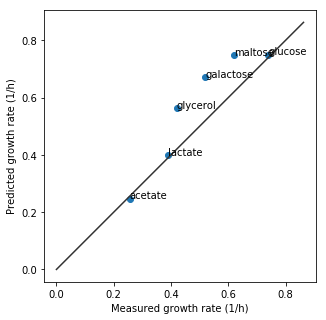

In [213]:
#sim_dict = {r['ex_rxn']:r['muopt'] for i,r in df_ijo.iterrows()}
#rxns_sorted = sorted([s[1] for s in sims], key=lambda x: sim_dict[x], reverse=True)
#substrates = rank_meas.keys()
#rank_pred = {k: rxns_sorted.index(k) for k in substrates}
#r_meas = [rank_meas[k] for k in substrates]
#r_pred = [rxns_sorted.index(k) for k in substrates]
# r_meas = rank_meas.values()
df_val = pd.merge(df_ijo, df_meas, on='ex_rxn')
xymax = max(df_val.growth_rate_1_h.max(), df_val.muopt.max())
plt.plot([0, xymax*1.15], [0, xymax*1.15], color='#333333')
plt.scatter(df_val.growth_rate_1_h, df_val.muopt)
#for k in substrates:
for i,r in df_val.iterrows():
    x = r['growth_rate_1_h']
    y = r['muopt']
    k = r['substrate']
    ls = plt.text(x, y, k)
ax = ls.axes
ax.set_aspect(1)
ax.figure.set_size_inches(5,5)
ax.set_xlabel('Measured growth rate (1/h)')
ax.set_ylabel('Predicted growth rate (1/h)')
# ax.set_xlabel('Measured rank')
# ax.set_ylabel('Predicted rank')

r,p = stats.pearsonr(df_val.growth_rate_1_h, df_val.muopt)
print 'Pearson r=%g (p=%g)' % (r,p)
r,p = stats.spearmanr(df_val.growth_rate_1_h, df_val.muopt)
print 'Spearman r=%g (p=%g)' % (r,p)
#r,p = stats.pearsonr(r_meas, r_pred)
#print 'r=%g (p=%g)' % (r,p)

# Using ME

In [214]:
from dynamicme.dynamic import DelayedDynamicME

dyme = DelayedDynamicME(solver)
dyme.delay_model.solver.set_realopts('lp', {'Feasibility tol':1e-15,'Optimality tol':1e-15})
dsolver = dyme.delay_model.solver

In [215]:
c0_dict = {'glc__D_e': 0.4,
           'lac__L_e': 0.4,
           'malt_e': 0.4,
           'gal_e': 0.4,
           'glyc_e':0.4,
           'ac_e': 0.0}

mids_remove = []
for mid,c in c0_dict.iteritems():
    try:        
        met = me.metabolites.get_by_id(mid)    
        c0_dict[met.id] = c / met.formula_weight * 1000
    except KeyError:
        warnings.warn('Model has no metabolite: %s. Will remove it from c0_dict' % mid)
        mids_remove.append(mid)

for mid in mids_remove:
    c0_dict.pop(mid)

### Set max uptake rate
LB_EX = -10.
LB_O2 = -20.

lb_dict={}
ub_dict={}

for mid in c0_dict.keys():
    try:
        rxn = dyme.get_exchange_rxn(mid)    
        if rxn.id is 'EX_o2_e':
            lb = LB_O2
        else:
            lb = LB_EX
        rxn.lower_bound = lb
        lb_dict[rxn.id] = lb
    except KeyError:
        warnings.warn('Model has no metabolite: '+ mid)

## Compute uptake hierarchy
- check growth on each individually
- order by growth rate
- that's the approximate hierarchy
- tune keffs until we get the hierarchy correct

In [216]:
rank_meas = {'EX_ac_e': 5,
             'EX_gal_e': 2,
             'EX_glc__D_e': 0,
             'EX_glyc_e': 4,
             'EX_lac__L_e': 1,
             'EX_malt_e': 3
            }    

In [217]:
import os
import ipyparallel as ipp

rc = ipp.Client()
dview = rc[:]

In [218]:
df_rmap.head()

,bigg_id,keff_nominal,mmol_gDW,name,reaction,rxn,subsystem
0,12DGR120tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C12:0)",12dgr120_p --> 12dgr120_c,12DGR120tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
1,12DGR140tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C14:0)",12dgr140_p --> 12dgr140_c,12DGR140tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
2,12DGR141tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C14:1)",12dgr141_p --> 12dgr141_c,12DGR141tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
3,12DGR160tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C16:0)",12dgr160_p --> 12dgr160_c,12DGR160tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"
4,12DGR161tipp,65.0,0.0,"1,2 diacylglycerol transport via flipping (periplasm to cytoplasm, n-C16:1)",12dgr161_p --> 12dgr161_c,12DGR161tipp_FWD_CPLX_dummy,"Transport, Inner Membrane"


In [229]:
def run_sim(arg_dict):
    rank_meas = {'EX_ac_e': 5,
             'EX_gal_e': 2,
             'EX_glc__D_e': 0,
             'EX_glyc_e': 4,
             'EX_lac__L_e': 1,
             'EX_malt_e': 3
            }    
    from dynamicme.tests.helpme import HelpME
    from stressme.model import update_stoich_expr

    helper = HelpME(prototyping=False)
    solver = helper.solver
    me = solver.me
    ### Scale all keffs uniformly in rxn set
    keff_scale = arg_dict['keff_scale']
    df_rmap = arg_dict['df_rmap']
    for i,row in df_rmap.iterrows():
        rxn = me.reactions.get_by_id(row['rxn'])
        rxn.keff = row['keff_nominal'] * keff_scale
        rxn.update()
        update_stoich_expr(solver, rxn=rxn)
    
    for rid in rank_meas.keys():
        rxn = me.reactions.get_by_id(rid)
        rxn.lower_bound = 0.
    ex_rxn = arg_dict['ex_rxn']
    rxn = me.reactions.get_by_id(ex_rxn)
    rxn.lower_bound = -10
    
    muopt,hs,x,cache = solver.bisectmu(basis=solver.feas_basis)
    if me.solution is None:
        stat = 1
        x_dict = None
    else:
        stat = me.solution.status
        x_dict = dict(me.solution.x_dict)
    row = {'ex_rxn':ex_rxn, 'muopt':muopt, 'stat':stat, 'x_dict':x_dict}
    return row

In [230]:
parargs = [{'ex_rxn':k, 'keff_scale':KEFF_SCALE, 'df_rmap':df_rmap} for k in rank_meas.keys()]

In [231]:
%%time
import scipy.stats as stats

results = dview.map_sync(run_sim, parargs)

CPU times: user 790 ms, sys: 63.3 ms, total: 853 ms
Wall time: 3min 38s


In [232]:
df_me = pd.DataFrame([{'ex_rxn':res['ex_rxn'], 'muopt':res['muopt']} for res in results])
df_me

,ex_rxn,muopt
0,EX_glyc_e,0.402344
1,EX_gal_e,0.391602
2,EX_lac__L_e,0.283203
3,EX_malt_e,0.407227
4,EX_ac_e,0.149414
5,EX_glc__D_e,0.416992


Pearson r=0.819387 (p=0.0459856)
Spearman r=0.942857 (p=0.00480466)


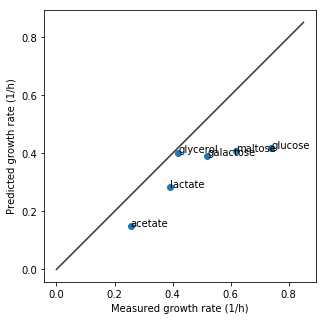

In [233]:
df_val = pd.merge(df_me, df_meas, on='ex_rxn')
xymax = max(df_val.growth_rate_1_h.max(), df_val.muopt.max())
plt.plot([0, xymax*1.15], [0, xymax*1.15], color='#333333')
plt.scatter(df_val.growth_rate_1_h, df_val.muopt)
#for k in substrates:
for i,r in df_val.iterrows():
    x = r['growth_rate_1_h']
    y = r['muopt']
    k = r['substrate']
    ls = plt.text(x, y, k)
ax = ls.axes
ax.set_aspect(1)
ax.figure.set_size_inches(5,5)
ax.set_xlabel('Measured growth rate (1/h)')
ax.set_ylabel('Predicted growth rate (1/h)')
# ax.set_xlabel('Measured rank')
# ax.set_ylabel('Predicted rank')

r,p = stats.pearsonr(df_val.growth_rate_1_h, df_val.muopt)
print 'Pearson r=%g (p=%g)' % (r,p)
r,p = stats.spearmanr(df_val.growth_rate_1_h, df_val.muopt)
print 'Spearman r=%g (p=%g)' % (r,p)
#r,p = stats.pearsonr(r_meas, r_pred)
#print 'r=%g (p=%g)' % (r,p)